**Smart Chunking for Confluence-Based Knowledge Retrieval**

**Introduction**

This project focuses on enhancing the knowledge retrieval system for Confluence pages by dynamically adapting the chunk size based on document characteristics. The primary goal is to improve retrieval accuracy and efficiency while optimizing Large Language Model (LLM) usage costs. While the chunking strategy has been modified, the embedding and indexing processes remain unchanged, using the default configurations of the `AzureCosmosDBVectorSearch` class.

In [ ]:
import os
from dotenv import load_dotenv

load_dotenv(override=True)


OPENAI_API_TYPE = "YOUR_API_TYPE"
OPENAI_API_VERSION = "YOUR_API_VERSION"
AZURE_OPENAI_ENDPOINT = "YOUR_ENDPOINT"
AZURE_OPENAI_LLM_DEPLOYMENT_NAME = "YOUR_LLM_DEPLOYMENT_NAME"
AZURE_OPENAI_LLM_MODEL_NAME = "YOUR_LLM_MODEL_NAME"
AZURE_OPENAI_EMBEDDING_DEPLOYMENT_NAME = "YOUR_EMBEDDING_DEPLOYMENT_NAME"
AZURE_OPENAI_EMBEDDING_MODEL_NAME = "YOUR_EMBEDDING_MODEL_NAME"
OPENAI_API_KEY = "YOUR_API_KEY"

CONFLUENCE_TOKEN = "YOUR_CONFLUENCE_TOKEN"

COSMOSDB_VCORE_CONNECTION_STRING = "YOUR_COSMOSDB_VCORE_CONNECTION_STRING"
COSMOSDB_NAMESPACE = "YOUR_COSMOSDB_NAMESPACE"

In [ ]:
from langchain.document_loaders import ConfluenceLoader
import pytesseract

# This section uses internal Confluence documents and cannot be shared.
# Replace this loader with your own Confluence space or another document source.


loader = ConfluenceLoader(
    url="https://your-confluence-domain.com",
    token=CONFLUENCE_TOKEN
)

confluence_documents = loader.load(
    space_key="SDV", 
    include_attachments=True, 
    limit=20,
    max_pages=1000,
)

print(confluence_documents[1])
print(f'{len(confluence_documents)} documents read from Confluence.')

In previous settings 3592 chunks of size 3592 were generated.

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# https://js.langchain.com/docs/modules/data_connection/document_transformers/#get-started-with-text-splitters
# How to chunk: https://www.pinecone.io/learn/chunking-strategies/
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1024, 
    chunk_overlap = 200,
    length_function = len)

splitted_documents = text_splitter.split_documents(confluence_documents)

print(f'{len(splitted_documents)} chunks generated.')

In [ ]:
# Embeddings by OpenAI
from langchain_openai import AzureOpenAIEmbeddings

# https://api.python.langchain.com/en/latest/embeddings/langchain_openai.embeddings.azure.AzureOpenAIEmbeddings.html
openai_embeddings = AzureOpenAIEmbeddings(
    azure_deployment=AZURE_OPENAI_EMBEDDING_DEPLOYMENT_NAME,
    openai_api_version=OPENAI_API_VERSION,
    # https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/models#gpt-4-and-gpt-4-turbo-preview
    model=AZURE_OPENAI_EMBEDDING_MODEL_NAME,
    embedding_ctx_length=8191, # default
    chunk_size= 1024 # Shall be the same value (ENV) as for the text embedding
)

In [ ]:
from langchain_community.vectorstores.azure_cosmos_db import (
    AzureCosmosDBVectorSearch,
    CosmosDBSimilarityType,
)
from pymongo import MongoClient

from langchain.chat_models import AzureChatOpenAI
from langchain.chains.qa_with_sources import load_qa_with_sources_chain

from langchain.schema import HumanMessage, SystemMessage


# LEARNINGS
# 1) CosmosDB RU connection string needs to be pulled from Instance Connection String directly (not from the DB)
# 2) Before connecting from local machine towards the DB make sure to open the firewall from Azure Portal (Networking)

_indexName = 'km-index'
_dbName, _collectionName = COSMOSDB_NAMESPACE.split(".")

client: MongoClient = MongoClient(COSMOSDB_VCORE_CONNECTION_STRING)
collection = client[_dbName][_collectionName]

# Clean MongoDB collection before inserting new data
collection.database.drop_collection(_collectionName)

# Chunk Size Prediction LLM
chunk_prediction_llm = AzureChatOpenAI(
    azure_deployment=AZURE_OPENAI_LLM_DEPLOYMENT_NAME, 
    temperature=0, 
)


*Smart Chunking:*


*   The core innovation is the `split_documents_smartly` function.
*   This function leverages a secondary LLM (`chunk_prediction_llm`) to analyze each Confluence page and predict an optimal chunk size based on its content.
*   The prompt emphasizes capturing complete sentences, considers code/tables, and aims for a balanced chunk count.
*   The predicted chunk size is then used with `RecursiveCharacterTextSplitter.from_tiktoken_encoder` to split the page into chunks.
*   **Key Improvement:** This allows chunk sizes to vary per document, unlike the fixed 1024-token size used previously.

In [ ]:
def split_documents_smartly(documents, llm):
    """Splits Confluence documents into chunks using dynamic chunk size prediction."""
    splitted_chunks = []
    for doc in documents:
        page_content = doc.page_content  # Access the page_content directly
        if not page_content:  # Handle cases where page_content is empty or None
            continue

        # Enhanced Prompt as a ChatMessage
        messages = [
            SystemMessage(
                content="Analyze the following Confluence page and suggest an appropriate chunk size in tokens (between 100 and 1024) for splitting it into semantically meaningful chunks:"
            ),
            HumanMessage(
                content=f"""
        Confluence Page Content (First 500 characters for brevity):
        {page_content[:500]}

        **Considerations:**
        - Prioritize capturing complete sentences or meaningful phrases within a chunk.
        - If the page contains code snippets or tables, consider smaller chunk sizes.
        - Aim for a balance between capturing context and minimizing the number of chunks.
        """
            ),
        ]

        response = llm(messages)
        try:
            chunk_size = int(response.content.strip())
            chunk_size = max(100, min(1024, chunk_size))
        except ValueError:
            chunk_size = 512
        
        text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
            chunk_size=chunk_size, chunk_overlap=200
        )
        chunks = text_splitter.split_documents([doc]) 
        splitted_chunks.extend(chunks)
    return splitted_chunks


*I took more than 5h to split documents:*

In [ ]:
# Splitting documents
splitted_documents = split_documents_smartly(confluence_documents, chunk_prediction_llm)

*Chunks overview:*

In [ ]:
print(f'{len(splitted_documents)} chunks generated.')

In [ ]:
import tiktoken

encoding = tiktoken.encoding_for_model(AZURE_OPENAI_LLM_MODEL_NAME)

for doc in splitted_documents:
    token_count = len(encoding.encode(doc.page_content))
    print(f"Document: {doc.metadata['title']}, Tokens: {token_count}")

*The smallest and the bigest chunk sizes:*

In [ ]:
import tiktoken

encoding = tiktoken.encoding_for_model(AZURE_OPENAI_LLM_MODEL_NAME)

smallest_chunk = min(splitted_documents, key=lambda x: len(encoding.encode(x.page_content)))
biggest_chunk = max(splitted_documents, key=lambda x: len(encoding.encode(x.page_content)))

print("Smallest Chunk (Token Count):")
print(f"  Content: {smallest_chunk.page_content}")
print(f"  Tokens: {len(encoding.encode(smallest_chunk.page_content))}")
print(f"  Metadata: {smallest_chunk.metadata}")

print("\nBiggest Chunk (Token Count):")
print(f"  Content: {biggest_chunk.page_content}")
print(f"  Tokens: {len(encoding.encode(biggest_chunk.page_content))}")
print(f"  Metadata: {biggest_chunk.metadata}")


In [ ]:

vectorstore = AzureCosmosDBVectorSearch.from_documents(
    splitted_documents,
    openai_embeddings,
    collection=collection,
    index_name=_indexName,
)

num_lists = 100
dimensions = 1536
similarity_algorithm = CosmosDBSimilarityType.COS

vectorstore.create_index(num_lists, dimensions, similarity_algorithm)

In [ ]:
from langchain.chat_models import AzureChatOpenAI
from langchain.chains.qa_with_sources import load_qa_with_sources_chain


# Setup of the LLM and the chain
llm = AzureChatOpenAI(
    azure_deployment=AZURE_OPENAI_LLM_DEPLOYMENT_NAME, 
    model=AZURE_OPENAI_LLM_MODEL_NAME,
    temperature=0.8
)

chain = load_qa_with_sources_chain(
    llm, 
    chain_type="stuff")


query = "YOUR_EXAMPLE_QUESTION"
query1 = "YOUR_EXAMPLE_QUESTION"


matching_docs = vectorstore.similarity_search(query)
matching_docs1 = vectorstore.similarity_search(query1)

answer = chain.run(input_documents=matching_docs, question=query)
answer1 = chain.run(input_documents=matching_docs1, question=query1)

print(query, "\n", answer)
print(query1, "\n", answer1)


**Observation:**

The smart chunking strategy does not consistently produce larger chunks than the fixed 1024-token method. In fact, it creates both smaller and significantly larger chunks. The overall impact on chunk count and LLM usage costs will depend on the specific distribution of chunk sizes within your dataset. While there might be a reduction in the number of chunks, the presence of very large chunks could potentially negate or even worsen the cost savings.

**Possible Explanations and Next Steps:**

1. **Chunk Prediction LLM:** The secondary LLM responsible for predicting chunk sizes might not be performing optimally. It could be:
   - Overestimating the complexity of some pages, leading to very small chunks.
   - Underestimating the complexity of other pages, resulting in very large chunks.

2. **Prompt Engineering:** The prompt used to guide the chunk prediction LLM might need refinement. It could be:
   - Too vague, not providing enough constraints on the desired chunk size range.
   - Too focused on specific elements (like sentences or code blocks), neglecting the overall document structure.

3. **Data Characteristics:** The nature of Confluence pages could be a factor. If pages have a very diverse range of content types and complexity levels, it might be inherently difficult for any single chunking strategy to find an optimal balance.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tiktoken
import pandas as pd


encoding = tiktoken.encoding_for_model(AZURE_OPENAI_LLM_MODEL_NAME)


def get_chunk_size(chunk):
    return len(encoding.encode(chunk.page_content))

chunk_sizes = [get_chunk_size(chunk) for chunk in splitted_documents]

df = pd.DataFrame(
    {
        "chunk_size": chunk_sizes,
        "title": [chunk.metadata["title"] for chunk in splitted_documents],
        "source": [chunk.metadata["source"] for chunk in splitted_documents],
    }
)

print("Summary Statistics:")
print(df["chunk_size"].describe())
print("\n")

lower_threshold = 50  
upper_threshold = 500  

small_outliers = df[df["chunk_size"] < lower_threshold]
large_outliers = df[df["chunk_size"] > upper_threshold]

print("Small Outliers:")
print(small_outliers.head())
print("\n")

print("Large Outliers:")
print(large_outliers.head())
print("\n")

plt.figure(figsize=(10, 6))
plt.hist(chunk_sizes, bins=30, edgecolor="k", alpha=0.7)
plt.xlabel("Chunk Size (Tokens)")
plt.ylabel("Frequency")
plt.title("Distribution of Chunk Sizes")

plt.axvline(lower_threshold, color="r", linestyle="dashed", linewidth=1)
plt.axvline(upper_threshold, color="r", linestyle="dashed", linewidth=1)

plt.show()


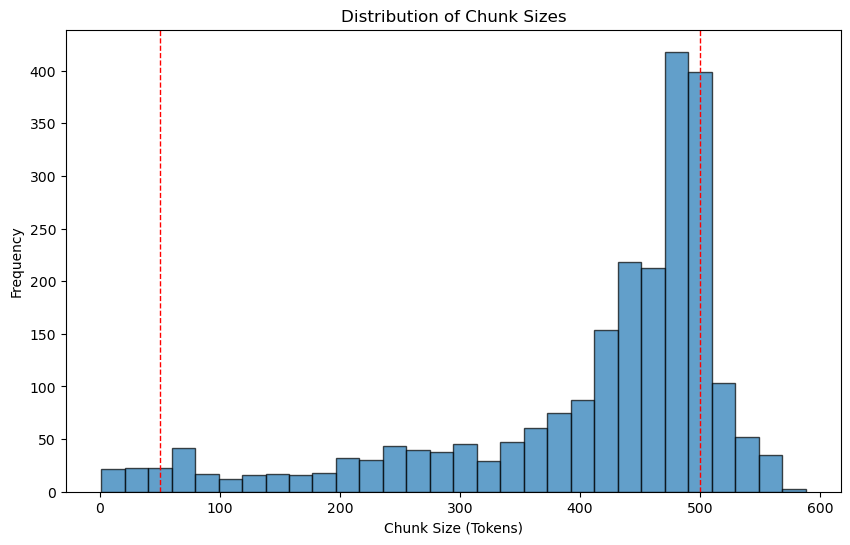